## GOBAI-O2-v1.0 (vertical mean: 0-200m; 200-600m)

In [1]:
import os
import xarray as xr
import numpy as np
import netCDF4
import seawater as sw
USER = os.environ['USER']

### vertically-regridded GOBAI O2 Obs

In [2]:
## monthly gridded O2/T/S data; 2004-2021
a1,a2,b1,b2 = [79, 131, 149, 301]
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/GOBAI_O2_verti_regrid_200401-201510_monthly.nc'
nc = netCDF4.Dataset(filename, 'r')
gobai_o2 = nc.variables['O2'][:,:,:,:-2]
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:-2]
z_t = nc.variables['z_t'][:]
nc.close()

### horizontally-regrided FOSI hindcast

In [4]:
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/FOSI_hindcast_O2_hori_regrid_200401-201510_monthly2.nc'
dset = xr.open_dataset(filename)
fosi_o2 = dset['O2'].isel(y=range(14,66),x=range(169,319)).values
dset

<xarray.Dataset>
Dimensions:  (z_t: 35, time: 154, y: 80, x: 360)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.277e+04 5.794e+04
  * time     (time) object 0305-02-01 00:00:00 ... 0317-11-01 00:00:00
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    O2       (time, z_t, y, x) float32 ...

In [5]:
np.shape(fosi_o2)

(154, 35, 52, 150)

In [6]:
np.shape(gobai_o2)

(154, 35, 52, 150)

In [7]:
gmask = gobai_o2.mask
fmask = np.isnan(fosi_o2)
gobai_o2.mask = gmask + fmask
fosi_o2 = np.ma.array(fosi_o2,mask=gmask+fmask)

### prepare for vertical mean

In [8]:
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/DPLE-FOSI_hindcast_T_S_O2_1948-2017_monthly.nc'
dset = xr.open_dataset(filename)
dz = dset['dz'][:35].values/1e2 # m
dz

array([10.      , 10.      , 10.      , 10.      , 10.      , 10.      ,
       10.      , 10.      , 10.      , 10.      , 10.      , 10.      ,
       10.      , 10.      , 10.      , 10.      , 10.196808, 10.564484,
       11.059951, 11.67807 , 12.424133, 13.309678, 14.35141 , 15.571259,
       16.996796, 18.662125, 20.609024, 22.888521, 25.562471, 28.70575 ,
       32.40837 , 36.777725, 41.940308, 48.042236, 55.247543],
      dtype=float32)

In [9]:
from math import sin, cos, sqrt, atan2, radians
def geo_dis(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [10]:
lon1 = lon + 0.5
lon1 = list(lon1)
lon1 = [lon1[0]-1] + lon1
lon1 = np.array(lon1)
lat1 = lat + 0.5
lat1 = list(lat1)
lat1 = [lat1[0]-1] + lat1
lat1 = np.array(lat1)
lon1

array([ 169.,  170.,  171.,  172.,  173.,  174.,  175.,  176.,  177.,
        178.,  179.,  180., -179., -178., -177., -176., -175., -174.,
       -173., -172., -171., -170., -169., -168., -167., -166., -165.,
       -164., -163., -162., -161., -160., -159., -158., -157., -156.,
       -155., -154., -153., -152., -151., -150., -149., -148., -147.,
       -146., -145., -144., -143., -142., -141., -140., -139., -138.,
       -137., -136., -135., -134., -133., -132., -131., -130., -129.,
       -128., -127., -126., -125., -124., -123., -122., -121., -120.,
       -119., -118., -117., -116., -115., -114., -113., -112., -111.,
       -110., -109., -108., -107., -106., -105., -104., -103., -102.,
       -101., -100.,  -99.,  -98.,  -97.,  -96.,  -95.,  -94.,  -93.,
        -92.,  -91.,  -90.,  -89.,  -88.,  -87.,  -86.,  -85.,  -84.,
        -83.,  -82.,  -81.,  -80.,  -79.,  -78.,  -77.,  -76.,  -75.,
        -74.,  -73.,  -72.,  -71.,  -70.,  -69.,  -68.,  -67.,  -66.,
        -65.,  -64.,

In [11]:
nlat = len(lat)
nlon = len(lon)
dx = np.zeros([nlat,nlon])
dy = dx.copy()
for ii in range(nlat):
    for jj in range(nlon):
        dx[ii,jj] = geo_dis(lat[ii],lon1[ii],lat[ii],lon1[ii+1])
        dy[ii,jj] = geo_dis(lat1[ii],lon[ii],lat1[ii+1],lon[ii])
darea = dx*dy # unit km*km

In [12]:
darea

array([[11977.98646161, 11977.98646161, 11977.98646161, ...,
        11977.98646161, 11977.98646161, 11977.98646161],
       [11922.09820353, 11922.09820353, 11922.09820353, ...,
        11922.09820353, 11922.09820353, 11922.09820353],
       [11862.57829301, 11862.57829301, 11862.57829301, ...,
        11862.57829301, 11862.57829301, 11862.57829301],
       ...,
       [ 5520.33704836,  5520.33704836,  5520.33704836, ...,
         5520.33704836,  5520.33704836,  5520.33704836],
       [ 5326.2608484 ,  5326.2608484 ,  5326.2608484 , ...,
         5326.2608484 ,  5326.2608484 ,  5326.2608484 ],
       [ 5130.56231078,  5130.56231078,  5130.56231078, ...,
         5130.56231078,  5130.56231078,  5130.56231078]])

In [13]:
dz = np.tile(dz[np.newaxis, :, np.newaxis, np.newaxis], [154, 1, nlat, nlon])
darea = np.tile(darea[np.newaxis, np.newaxis, :, :], [154, 35, 1, 1])
dvol = dz * darea
dvol = np.ma.array(dvol, mask=fosi_o2.mask)
uo2_gobai = gobai_o2 * dvol
uo2_fosi = fosi_o2 * dvol
np.shape(uo2_fosi)

(154, 35, 52, 150)

In [14]:
z_t

masked_array(data=[  5.     ,  15.     ,  25.     ,  35.     ,  45.     ,
                    55.     ,  65.     ,  75.     ,  85.     ,  95.     ,
                   105.     , 115.     , 125.     , 135.     , 145.     ,
                   155.     , 165.0984 , 175.47905, 186.29128, 197.66028,
                   209.71138, 222.57828, 236.40883, 251.37016, 267.6542 ,
                   285.48364, 305.11923, 326.86798, 351.09348, 378.22763,
                   408.78464, 443.3777 , 482.73672, 527.728  , 579.37286],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

## Upper 200 m Vertical Mean

In [15]:
gobai_o2_200m = np.sum(uo2_gobai[:, :20], axis=1) / np.sum(dvol[:, :20], axis=1)
gobai_o2_600m = np.sum(uo2_gobai[:, 20:35], axis=1) / np.sum(dvol[:, 20:35], axis=1)
fosi_o2_200m = np.sum(uo2_fosi[:, :20], axis=1) / np.sum(dvol[:, :20], axis=1)
fosi_o2_600m = np.sum(uo2_fosi[:, 20:35], axis=1) / np.sum(dvol[:, 20:35], axis=1)

In [16]:
dsf = xr.Dataset()
time = range(154)
dsf['GOBAI_O2_0-200m'] = xr.DataArray(data=gobai_o2_200m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))
dsf['GOBAI_O2_200-600m'] = xr.DataArray(data=gobai_o2_600m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))
dsf['FOSI_O2_0-200m'] = xr.DataArray(data=fosi_o2_200m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))
dsf['FOSI_O2_200-600m'] = xr.DataArray(data=fosi_o2_600m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))

In [17]:
dsf.load()

<xarray.Dataset>
Dimensions:            (time: 154, lat: 52, lon: 150)
Coordinates:
  * time               (time) int64 0 1 2 3 4 5 6 ... 148 149 150 151 152 153
  * lat                (lat) float32 14.5 15.5 16.5 17.5 ... 62.5 63.5 64.5 65.5
  * lon                (lon) float32 169.5 170.5 171.5 ... -43.5 -42.5 -41.5
Data variables:
    GOBAI_O2_0-200m    (time, lat, lon) float64 197.3 197.9 197.9 ... nan nan
    GOBAI_O2_200-600m  (time, lat, lon) float64 93.53 94.36 95.6 ... nan nan nan
    FOSI_O2_0-200m     (time, lat, lon) float64 179.7 179.9 180.1 ... nan nan
    FOSI_O2_200-600m   (time, lat, lon) float64 58.55 57.84 56.13 ... nan nan

In [18]:
dsf.to_netcdf(f'{path}/GOBAI_FOSI_O2_vertical_mean_200401-201510_monthly.nc', mode='w')

# Calculate LME-averaged O2

In [19]:
datadir = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME-mask-POP_gx1v6.nc' % datadir
ds1 = xr.open_dataset(filename)
lme_mask = ds1['lme_mask']
tlon = ds1['TLONG'].values - 360.
tlat = ds1['TLAT'].values
lme = [1,2,3,4,5,6,7,8,9,10,65]

In [20]:
tlon

array([[-39.43749108, -38.31249105, -37.18749102, ..., -42.81249117,
        -41.68749114, -40.56249111],
       [-39.43749108, -38.31249105, -37.18749102, ..., -42.81249117,
        -41.68749114, -40.56249111],
       [-39.43749108, -38.31249105, -37.18749102, ..., -42.81249117,
        -41.68749114, -40.56249111],
       ...,
       [-39.74866914, -39.24619887, -38.74422675, ..., -41.25575544,
        -40.75378332, -40.25130857],
       [-39.76540523, -39.29641051, -38.82792558, ..., -41.17205661,
        -40.70357168, -40.23457279],
       [-39.78349101, -39.3506697 , -38.91836527, ..., -41.08161692,
        -40.6493125 , -40.21648733]])

In [21]:
lon[:11] = lon[:11] - 360.
lon1,lat1 = np.meshgrid(lon,lat)

In [22]:
mask_lme = np.ma.zeros(np.shape(lon1))
mask_lme.mask = True
for nn,box in zip(range(len(lme)),lme):
    print(box)
    latloc, lonloc = np.where(lme_mask == box)
    for bb in range(len(latloc)):
        rlon = tlon[latloc[bb], lonloc[bb]]
        rlat = tlat[latloc[bb], lonloc[bb]]
        dis = (lon1-rlon)**2 + (lat1-rlat)**2
        yloc, xloc = np.where(dis==dis.min())
        if box == 65:
            box = 11
        mask_lme[yloc,xloc] = box

1
2
3
4
5
6
7
8
9
10
65


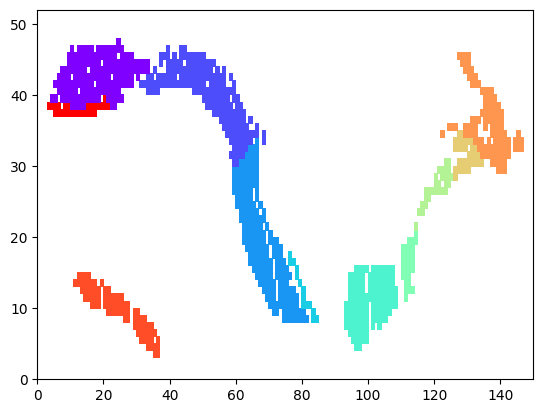

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.pcolor(mask_lme,cmap=cm.rainbow)
plt.show()

In [28]:
filename = f'{path}/FOSI_hindcast_LME_hori_regrid.nc'
ds2 = xr.open_dataset(filename)
mask_lme2 = ds2['lme_mask'].isel(y=range(14,66),x=range(169,319)).values
for nn,box in zip(range(len(lme)),lme):
    print(box)
    latloc, lonloc = np.where(np.abs(mask_lme2-box) <= 0.2)
    for bb in range(len(latloc)):
        if box == 65:
            box = 11
        mask_lme[latloc[bb], lonloc[bb]] = box
mask_lme.mask[9,107]=True

1
2
3
4
5
6
7
8
9
10
65


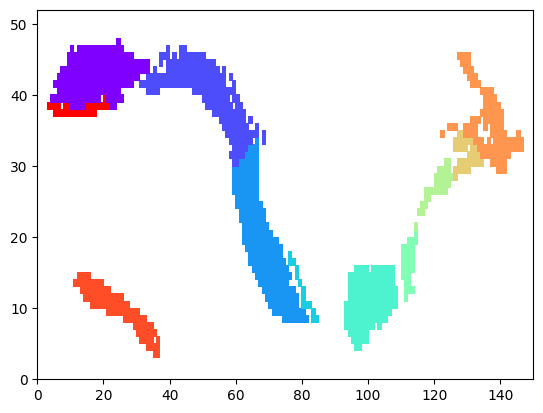

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.pcolor(mask_lme,cmap=cm.rainbow)
plt.show()

In [30]:
gobaio21 = dsf['GOBAI_O2_0-200m'].values
gobaio22 = dsf['GOBAI_O2_200-600m'].values
fosio21 = dsf['FOSI_O2_0-200m'].values
fosio22 = dsf['FOSI_O2_200-600m'].values
gobaio21 = np.ma.array(gobaio21,mask=np.isnan(gobaio21))
gobaio22 = np.ma.array(gobaio22,mask=np.isnan(gobaio22))
fosio21 = np.ma.array(fosio21,mask=np.isnan(fosio21))
fosio22 = np.ma.array(fosio22,mask=np.isnan(fosio22))

In [31]:
boxPhi = xr.Dataset()
phi_box1 = np.ma.zeros([len(lme), 154])
phi_box1.mask = True
phi_box2 = phi_box1.copy()
phi_box3 = phi_box1.copy()
phi_box4 = phi_box1.copy()
for nn,box in zip(range(len(lme)),lme):
    print(box)
    latloc, lonloc = np.where(mask_lme == (nn+1))
    ar1 = np.ma.zeros([len(latloc),154])
    ar2 = ar1.copy()
    ar3 = ar1.copy()
    ar4 = ar1.copy()
    for bb in range(len(latloc)):
        ar1[bb] = gobaio21[:,latloc[bb], lonloc[bb]]
        ar2[bb] = gobaio22[:,latloc[bb], lonloc[bb]]
        ar3[bb] = fosio21[:,latloc[bb], lonloc[bb]]
        ar4[bb] = fosio22[:,latloc[bb], lonloc[bb]]

    phi_box1[nn] = np.mean(ar1,axis=0)
    phi_box2[nn] = np.mean(ar2,axis=0)
    phi_box3[nn] = np.mean(ar3,axis=0)
    phi_box4[nn] = np.mean(ar4,axis=0)
boxPhi['GOBAI_O2_0-200m'] = xr.DataArray(data=phi_box1, coords=dict(lme=('lme', lme), time=('time', range(154))), dims=('lme','time'))
boxPhi['GOBAI_O2_200-600m'] = xr.DataArray(data=phi_box2, coords=dict(lme=('lme', lme), time=('time', range(154))), dims=('lme','time'))
boxPhi['FOSI_O2_0-200m'] = xr.DataArray(data=phi_box3, coords=dict(lme=('lme', lme), time=('time', range(154))), dims=('lme','time'))
boxPhi['FOSI_O2_200-600m'] = xr.DataArray(data=phi_box4, coords=dict(lme=('lme', lme), time=('time', range(154))), dims=('lme','time'))

1
2
3
4
5
6
7
8
9
10
65


In [32]:
boxPhi.load()

<xarray.Dataset>
Dimensions:            (lme: 11, time: 154)
Coordinates:
  * lme                (lme) int64 1 2 3 4 5 6 7 8 9 10 65
  * time               (time) int64 0 1 2 3 4 5 6 ... 148 149 150 151 152 153
Data variables:
    GOBAI_O2_0-200m    (lme, time) float64 259.1 263.7 265.4 ... 241.8 239.1
    GOBAI_O2_200-600m  (lme, time) float64 69.6 70.97 76.11 ... 75.07 71.81
    FOSI_O2_0-200m     (lme, time) float64 240.4 248.1 253.0 ... 200.9 195.7
    FOSI_O2_200-600m   (lme, time) float64 35.13 35.01 35.05 ... 42.07 41.49

In [34]:
boxPhi.to_netcdf(f'{path}/GOBAI_FOSI_O2_LME_mean_200401-201510_monthly.nc', mode='w')

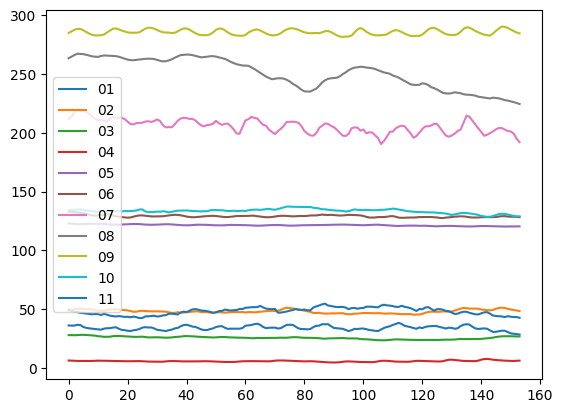

In [94]:
plt.plot(phi_box4.T)
plt.legend(['01','02','03','04','05','06','07','08','09','10','11'])
plt.show()